In [1]:
%%javascript
// Run for table of contents.
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Tests with NIPS data

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel
from imp import reload
from pprint import pprint
from random import sample
import bokeh
import os
import re
import line_profiler
from sklearn.manifold import TSNE

import logging

from gensim.models import AuthorTopicModel
from gensim.models import atmodel
from gensim.models import LdaModel
from gensim.models import ldamodel

from time import time

%matplotlib inline

In [3]:
# Configure logging.

log_dir = '../../../log_files/log.log'  # On my own machine.
#log_dir = '../../../../log_files/log.log'  # On Hetzner

logger = logging.getLogger()
fhandler = logging.FileHandler(filename=log_dir, mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

## Load and prepare data structure

In [4]:
# Folder containing all NIPS papers.
data_dir = '../../../../data/nipstxt/'  # On my own machine.
#data_dir = '../../../nipstxt/'  # On Hetzner.

# Folders containin individual NIPS papers.
yrs = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#yrs = ['00', '01', '02']
dirs = ['nips' + yr for yr in yrs]

# Get all document texts and their corresponding IDs.
docs = []
doc_ids = []
for yr_dir in dirs:
    files = os.listdir(data_dir + yr_dir)  # List of filenames.
    for filen in files:
        # Get document ID.
        (idx1, idx2) = re.search('[0-9]+', filen).span()  # Matches the indexes of the start end end of the ID.
        doc_ids.append(yr_dir[4:] + '_' + str(int(filen[idx1:idx2])))
        
        # Read document text.
        # Note: ignoring characters that cause encoding errors.
        with open(data_dir + yr_dir + '/' + filen, errors='ignore', encoding='utf-8') as fid:
            txt = fid.read()
        docs.append(txt)

In [5]:
filenames = [data_dir + 'idx/a' + yr + '.txt' for yr in yrs]  # Using the years defined in previous cell.

# Get all author names and their corresponding document IDs.
author2id = dict()
author2doc = dict()
i = 0
for yr in yrs:
    filename = data_dir + 'idx/a' + yr + '.txt'
    for line in open(filename, errors='ignore', encoding='utf-8'):
        contents = re.split(',', line)
        author_name = (contents[1] + contents[0]).strip()
        author_name = re.sub('\s', '', author_name)
        ids = [c.strip() for c in contents[2:]]
        if not author2doc.get(author_name):
            author2doc[author_name] = []
            author2id[author_name] = i
            i += 1
        
        author2doc[author_name].extend([yr + '_' + id for id in ids])
        

In [6]:
id2author = dict(zip(author2id.values(), author2id.keys()))

In [7]:
# Use an integer ID in author2doc, instead of the IDs provided in the NIPS dataset.

# Mapping from ID of document in NIPS datast, to an integer ID.
doc_id_dict = dict(zip(doc_ids, range(len(doc_ids))))

for a, a_doc_ids in author2doc.items():
    for i, doc_id in enumerate(a_doc_ids):
        author2doc[a][i] = doc_id_dict[doc_id]

## Pre-process and vectorize data

In [8]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [9]:
# Lemmatize the documents.

# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [10]:
# Compute bigrams.

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/home/olavur/Dropbox/my_folder/workstuff/DTU/thesis/code/gensim/gensim/models/phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

In [12]:
# Remove rare and common tokens.

# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 20
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

dict0 = dictionary[0]  # This sort of "initializes" dictionary.id2token.

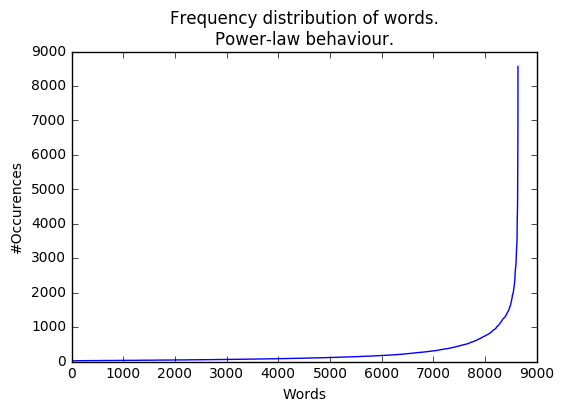

In [13]:
# Frequency distribution of words.

one_doc = []
for doc in docs:
    one_doc.extend(doc)

bow = dictionary.doc2bow(one_doc)
word_freq = [cnt for _, cnt in bow]

plt.plot(sorted(word_freq))
plt.xlabel('Words')
plt.ylabel('#Occurences')
plt.title('Frequency distribution of words.\nPower-law behaviour.')
plt.show()

In [14]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

# Serialize the corpus.
#MmCorpus.serialize('/tmp/corpus.mm', corpus)
#corpus = MmCorpus('/tmp/corpus.mm')

In [15]:
doc2author = atmodel.construct_doc2author(author2doc=author2doc, corpus=corpus)

In [16]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of authors: 2479
Number of unique tokens: 8640
Number of documents: 1740


## Train model

In [17]:
reload(atmodel)
AuthorTopicModel = atmodel.AuthorTopicModel
reload(ldamodel)
LdaModel = ldamodel.LdaModel

In [18]:
%time model = AuthorTopicModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, \
                author2doc=author2doc, doc2author=doc2author, var_lambda=None,  \
                chunksize=2000, passes=10, update_every=1, \
                alpha='auto', eta='auto', decay=0.5, offset=1.0,  \
                eval_every=0, iterations=1, gamma_threshold=1e-10,  \
                minimum_probability=0.01, random_state=1, ns_conf={},\
                serialized=False, serialization_path='/tmp/model_serializer.mm')


CPU times: user 16.3 s, sys: 6.8 s, total: 23.1 s
Wall time: 15.3 s


In [209]:
os.remove('/tmp/model_serializer.mm')

In [51]:
corpus_words = sum(cnt for document in corpus for _, cnt in document)
model.bound(corpus, author2doc=author2doc, doc2author=doc2author) / corpus_words

-7.6174788187032805

In [53]:
corpus_words = sum(cnt for document in corpus for _, cnt in document)
model.bound(corpus, author2doc=author2doc, doc2author=doc2author) / corpus_words

-7.8623202660656561

In [54]:
model.show_topics(num_topics=10)

[(0,
  '0.008*"bound" + 0.007*"class" + 0.006*"let" + 0.006*"generalization" + 0.005*"theorem" + 0.004*"solution" + 0.004*"xi" + 0.004*"threshold" + 0.004*"dimension" + 0.004*"approximation"'),
 (1,
  '0.007*"gaussian" + 0.007*"mixture" + 0.006*"likelihood" + 0.006*"estimate" + 0.006*"density" + 0.005*"prior" + 0.005*"bayesian" + 0.004*"matrix" + 0.004*"approximation" + 0.004*"log"'),
 (2,
  '0.022*"neuron" + 0.012*"cell" + 0.010*"circuit" + 0.008*"spike" + 0.007*"chip" + 0.007*"analog" + 0.006*"signal" + 0.006*"synaptic" + 0.006*"firing" + 0.006*"response"'),
 (3,
  '0.011*"action" + 0.010*"control" + 0.009*"policy" + 0.007*"optimal" + 0.007*"reinforcement" + 0.005*"decision" + 0.005*"reinforcement_learning" + 0.005*"controller" + 0.004*"dynamic" + 0.004*"memory"'),
 (4,
  '0.020*"image" + 0.008*"layer" + 0.008*"cell" + 0.008*"object" + 0.007*"response" + 0.007*"stimulus" + 0.006*"map" + 0.005*"region" + 0.005*"visual" + 0.004*"connection"'),
 (5,
  '0.008*"control" + 0.007*"trajector

In [57]:
name = 'YaserS.Abu-Mostafa'
print('\n%s' % name)
print('Docs:', author2doc[name])
pprint(model.get_author_topics(name))

name = 'GeoffreyE.Hinton'
print('\n%s' % name)
print('Docs:', author2doc[name])
pprint(model.get_author_topics(name))

name = 'MichaelI.Jordan'
print('\n%s' % name)
print('Docs:', author2doc[name])
pprint(model.get_author_topics(name))

name = 'JamesM.Bower'
print('\n%s' % name)
print('Docs:', author2doc[name])
pprint(model.get_author_topics(name))


YaserS.Abu-Mostafa
Docs: [62, 643, 1161]
[(0, 0.34245164076594642),
 (1, 0.17017191105426388),
 (2, 0.033106331294519953),
 (3, 0.071767707328752081),
 (7, 0.3690893484110731)]

GeoffreyE.Hinton
Docs: [56, 143, 284, 230, 197, 462, 463, 430, 688, 784, 826, 848, 869, 1387, 1684, 1728]
[(1, 0.51858687662480019), (4, 0.47852645782018649)]

MichaelI.Jordan
Docs: [237, 487, 442, 677, 753, 747, 863, 859, 934, 925, 848, 971, 907, 1193, 1235, 1155, 1249, 1352, 1413, 1297, 1658]
[(1, 0.78772934917486725), (3, 0.05820455979213638), (5, 0.15391613511638721)]

JamesM.Bower
Docs: [17, 48, 58, 131, 101, 126, 127, 281, 208, 225]
[(2, 0.39114236445750894), (4, 0.60853296871043705)]


In [31]:
%time model.top_topics(corpus)

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


[([(0.017630870907064309, 'cell'),
   (0.0078679276589406107, 'stimulus'),
   (0.0070952788888263103, 'cortex'),
   (0.0067363562965421569, 'response'),
   (0.0055064719206805021, 'potential'),
   (0.00502769057019916, 'firing'),
   (0.00498406866000218, 'activity'),
   (0.0049622639080422956, 'map'),
   (0.004606433753510524, 'brain'),
   (0.0045401006446385483, 'fig'),
   (0.0044771307512187272, 'synaptic'),
   (0.0044637900045596058, 'region'),
   (0.0041009965534344918, 'spike'),
   (0.004011618098692782, 'phase'),
   (0.0033931058874009184, 'fiber'),
   (0.0032227897579595213, 'cortical'),
   (0.003122729100134052, 'current'),
   (0.0028684658338489237, 'et'),
   (0.002864435489459746, 'threshold'),
   (0.0028207201853967271, 'matrix')],
  -152.57713872126598),
 ([(0.0092927614119881902, 'vector'),
   (0.0080019378496359629, 'node'),
   (0.0044853942434458782, 'analog'),
   (0.0044014322994239165, 'memory'),
   (0.0043900396166045826, 'activation'),
   (0.0041866988700918501, 'syn

In [177]:
model.update()

-6.75334000877
-6.70998344096
-6.68882122239
-6.6720780584
-6.65790946046
-6.64568753857
-6.63508575556
-6.62586073078
-6.6178073486
-6.61074947975


### Similarities

In [41]:
# Generate a similarity object for the transformed corpus.
index = gensim.similarities.MatrixSimilarity(model[list(id2author.values())])

In [42]:
# Get similarities to some author.
author_name = 'Geoffrey E. Hinton'
sims = index[model[author_name]]
# Print the top 10 closest matches.
pprint(sorted(list(enumerate(sims)), reverse=True, key=lambda x: x[1])[:10])

[(251, 1.0),
 (196, 0.94725358),
 (359, 0.94520926),
 (166, 0.94345462),
 (310, 0.94230127),
 (32, 0.93244135),
 (115, 0.92903757),
 (211, 0.92358959),
 (531, 0.92228365),
 (273, 0.91858578)]


### Serialized corpus stuff

In [83]:
from itertools import chain
from shutil import copyfile

In [92]:
corpus = []
gensim.corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus)
corpus = gensim.corpora.MmCorpus('/tmp/corpus.mm')

In [94]:
corpus2 = [[(10,1)]]
corpus_both = chain(corpus, corpus2)
copyfile('/tmp/corpus.mm', '/tmp/corpus.mm.tmp')
corpus.input = '/tmp/corpus.mm.tmp'
gensim.corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus_both)
corpus = gensim.corpora.MmCorpus('/tmp/corpus.mm')

### Vectorization speed-up

In [145]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print('Speed-up', 2.64 / 0.397)

Number of authors: 166
Number of unique tokens: 681
Number of documents: 90
Speed-up 6.6498740554156175


In [161]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print('Speed-up', 15.1 / 2.97)

Number of authors: 536
Number of unique tokens: 2245
Number of documents: 286
Speed-up 5.084175084175084


In [178]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print('Speed-up', (2 * 60 + 58) / (1 * 60 + 13))

Number of authors: 2720
Number of unique tokens: 8640
Number of documents: 1740
Speed-up 2.4383561643835616


### Test on a small dataset

In [202]:
n_docs = 10

from copy import deepcopy

small_doc2author = deepcopy(dict(list(doc2author.items())[:n_docs]))
small_doc2author = dict(small_doc2author)

small_corpus = corpus[:n_docs]

In [203]:
authors_ids = set()
for d, a_doc_ids in small_doc2author.items():
    for a in a_doc_ids:
        authors_ids.add(a)

authors_ids = list(authors_ids)
author_id_dict = dict(zip(authors_ids, range(len(authors_ids))))

In [204]:
for d, a_ids in small_doc2author.items():
    for i, a in enumerate(a_ids):
        small_doc2author[d][i] = author_id_dict[a]

In [205]:
# Make a mapping from author IDs to document IDs.
small_author2doc = {}
for a in range(len(author_id_dict)):
    small_author2doc[a] = []
    for d, a_ids in small_doc2author.items():
        if a in a_ids:
            small_author2doc[a].append(d)

In [206]:

author_id_dict_rev = dict(zip(range(len(authors_ids)), authors_ids))

small_id2author = {}
for a, a_id in author_id_dict_rev.items():
    small_id2author[a] = id2author[a_id]

In [207]:
print('phi is %d x %d x %d (%d elements)' %(len(small_corpus), len(dictionary.id2token), 10,
                                            len(small_corpus) * len(dictionary.id2token) * 10))
print('mu is %d x %d x %d (%d elements)' %(len(small_corpus), len(dictionary.id2token), len(small_author2doc),
                                            len(small_corpus) * len(dictionary.id2token) * len(small_author2doc)))

phi is 10 x 681 x 10 (68100 elements)
mu is 10 x 681 x 21 (143010 elements)


## LDA

In [120]:
reload(ldamodel)
LdaModel = ldamodel.LdaModel

In [121]:
%time lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, passes=10, gamma_threshold=1e-10, \
               iterations=10, alpha='symmetric', eta='symmetric', eval_every=0, chunksize=2000, random_state=1)

CPU times: user 3.13 s, sys: 4 ms, total: 3.14 s
Wall time: 3.14 s


In [185]:
%time lda_bound = lda.bound(sample(corpus, 10))
print('Bound: %.3e' % lda_bound)

CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 303 ms
Bound: -2.424e+05


In [326]:
lda.show_topics()

[(0,
  '0.014*"hidden" + 0.014*"speech" + 0.011*"recognition" + 0.007*"hidden_unit" + 0.006*"propagation" + 0.006*"trained" + 0.006*"back_propagation" + 0.006*"test" + 0.005*"image" + 0.005*"classification"'),
 (1,
  '0.011*"field" + 0.008*"receptive" + 0.008*"cell" + 0.008*"receptive_field" + 0.007*"direction" + 0.007*"energy" + 0.007*"motion" + 0.006*"visual" + 0.006*"noise" + 0.005*"activity"'),
 (2,
  '0.011*"region" + 0.009*"memory" + 0.009*"delay" + 0.008*"chain" + 0.007*"fig" + 0.006*"matrix" + 0.006*"cell" + 0.006*"hopfield" + 0.005*"field" + 0.005*"stability"'),
 (3,
  '0.026*"cell" + 0.010*"circuit" + 0.010*"response" + 0.010*"chip" + 0.010*"synaptic" + 0.010*"stimulus" + 0.009*"synapse" + 0.009*"cortex" + 0.008*"synapsis" + 0.008*"pulse"'),
 (4,
  '0.018*"node" + 0.012*"activation" + 0.010*"processor" + 0.009*"object" + 0.008*"role" + 0.006*"connectionist" + 0.005*"current" + 0.005*"element" + 0.005*"machine" + 0.005*"update"'),
 (5,
  '0.017*"vector" + 0.012*"hidden" + 0.00

## Plots

In [32]:
from bokeh.io import output_notebook, output_file
from bokeh.models.layouts import Row, Column
from bokeh.models import Title, Legend, HoverTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.embed import file_html
from bokeh.resources import CDN

In [26]:
output_notebook()
output_file('bokeh_plot.html')

### t-SNE author bubble chart

In [22]:
tsne = TSNE(n_components=2, random_state=0)
_ = tsne.fit_transform(model.state.gamma)  # Result stored in tsne.embedding_

In [27]:
x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = list(model.id2author.values())

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
radii = [len(author2doc[a]) * scale for a in author_names]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            radii=radii,
        )
    )

hover = HoverTool(
        tooltips=[
        ("index", "$index"),
        ("author", "@author_names"),
        ("(x,y)", "($x, $y)"),
        ("radius", "@radii"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

### Auto alpha/eta bound

In [131]:
sym_bound = [-8.2268124131006175, -7.0028312886986592, -6.9983353496896177, -6.9920334045252472, -6.9834462646550692, -6.9724080682148131, -6.959010673469697, -6.9436014751446384, -6.9267331557797345, -6.9090211704296633]
alpha_auto_bound = [-8.2268124131006175, -6.9932405146123067, -6.9832943275841428, -6.9727565892336711, -6.9609464524488551, -6.9476614401472379, -6.9330202055642625, -6.9173822631441642, -6.9012200919426148, -6.8849715273282976]
eta_auto = [-8.2268124131006175, -6.9632952107352324, -6.9370024957065883, -6.9136966964250792, -6.8914783308986083, -6.8695469093457477, -6.8478606164307889, -6.8268741286187042, -6.8072291640504838, -6.7894361810128938]
both_auto = [-8.2268124131006175, -6.9537044366488798, -6.9219607839123887, -6.894414237250329, -6.8689542686648819, -6.8447258437974066, -6.8216878633917295, -6.8002809924812544, -6.7810529233013082, -6.7643492394144529]

In [134]:
iterations = range(10)

p1 = figure(title='Variational lower bound', x_axis_label='Iterations', y_axis_label='Per word bound')
s1 = p1.line(iterations, sym_bound, color='red')
p1.circle(iterations, sym_bound, color='red')
s2 = p1.line(iterations, alpha_auto_bound, color='blue')
p1.circle(iterations, alpha_auto_bound, color='blue')
s3 = p1.line(iterations, eta_auto, color='green')
p1.circle(iterations, eta_auto, color='green')
s4 = p1.line(iterations, both_auto, color='black')
p1.circle(iterations, both_auto, color='black')
legend = Legend(items=[
        ('both sym', [s1]),
        ('alpha auto', [s2]),
        ('eta auto', [s3]),
        ('both auto', [s4]),
    ], location=(-150.0, -200.0))
p1.add_layout(legend, 'right')
p1.plot_height=400
p1.plot_width=600
p1.toolbar_location = None

show(p1)

## Line profiling

In [198]:
reload(atmodel)
AuthorTopicModel = atmodel.AuthorTopicModel

In [199]:
model = AuthorTopicModel(corpus=None, num_topics=10, id2word=dictionary.id2token, id2author=id2author, \
                   author2doc=author2doc, doc2author=doc2author, threshold=1e-10, \
                   iterations=1, passes=1, alpha=None, eta=None, decay=0.5, offset=1.0, \
                   eval_every=0, random_state=1, var_lambda=None)
profile = line_profiler.LineProfiler(model.inference)
result = profile.runcall(model.inference, corpus=corpus)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 728.228 s
File: /home/olavur/Dropbox/my_folder/workstuff/DTU/thesis/code/gensim/gensim/models/atmodel.py
Function: inference at line 152

Line #      Hits         Time  Per Hit   % Time  Line Contents
   152                                               def inference(self, corpus=None, var_lambda=None):
   153         1            4      4.0      0.0          if corpus is None:
   154                                                       # TODO: is copy necessary here?
   155                                                       corpus = self.corpus.copy()
   156                                           
   157         1            5      5.0      0.0          self.num_docs = len(corpus)  # TODO: this needs to be different if the algorithm is truly online.
   158                                           
   159         1          355    355.0      0.0          logger.info('Starting inference. Training on %d documents.', len(corpus))
   160            

### Disjoint set stuff

In [20]:
def find_disjoint_sets(d):
    while True:
        for tuple_, set1 in d.items():
            try:
                match = next(k for k, set2 in d.items() if k != tuple_ and set1 & set2)
            except StopIteration:
                # no match for this key - keep looking
                continue
            else:
                #print('merging', tuple(set1), match)
                d[tuple_] = set1 | d.pop(match)
                break
        else:
            # no match for any key - we are done!
            break

    output = sorted(tuple(s) for s in d.values())
    
    return output

In [21]:
start = time()

thing = {a: set(_list) for a, _list in author2doc.items()}
disjoint_authors = find_disjoint_sets(thing)
print(disjoint_authors)
print(len(disjoint_authors))

print(time() - start)

[(0,), (1,), (2,), (3,), (4,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16, 63, 39), (18,), (19, 59), (20,), (21,), (22,), (23,), (24, 53), (25, 84), (26,), (27,), (28,), (29,), (30,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48, 17, 58, 5), (49,), (50,), (51,), (52,), (54,), (55,), (56,), (57,), (60,), (61,), (62,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73, 31), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (85,), (86,), (87,), (88,), (89,)]
81
0.0870358943939209


## LDA author-topic hack

In [132]:
author_corpus = []
for a, doc_ids in author2doc.items():
    temp = {}
    for d in doc_ids:
        for v, cnt in corpus[d]:
            if temp.get(v):
                temp[v] += cnt
            else:
                temp[v] = cnt
    author_corpus.append(list(temp.items()))

In [133]:
reload(gensim.models.ldamodel)
LdaModel = gensim.models.ldamodel.LdaModel

In [134]:
%time lda = LdaModel(corpus=author_corpus, num_topics=10, id2word=dictionary.id2token, passes=10, \
               iterations=100, alpha='symmetric', eta='symmetric', eval_every=0, chunksize=2000, random_state=1)

CPU times: user 4min 2s, sys: 7min 16s, total: 11min 18s
Wall time: 3min 25s


In [135]:
lda.show_topics()

[(0,
  '0.019*"signal" + 0.017*"component" + 0.015*"source" + 0.009*"independent" + 0.009*"ica" + 0.008*"noise" + 0.008*"eeg" + 0.008*"frequency" + 0.007*"response" + 0.007*"separation"'),
 (1,
  '0.005*"policy" + 0.005*"optimal" + 0.005*"bound" + 0.005*"action" + 0.005*"kernel" + 0.005*"let" + 0.004*"xi" + 0.004*"class" + 0.004*"decision" + 0.004*"reinforcement"'),
 (2,
  '0.010*"control" + 0.010*"cluster" + 0.009*"distance" + 0.008*"image" + 0.007*"clustering" + 0.007*"class" + 0.006*"nonlinear" + 0.006*"classification" + 0.006*"controller" + 0.004*"measure"'),
 (3,
  '0.028*"image" + 0.013*"object" + 0.011*"visual" + 0.009*"motion" + 0.007*"position" + 0.006*"field" + 0.006*"direction" + 0.005*"filter" + 0.005*"pixel" + 0.005*"view"'),
 (4,
  '0.013*"layer" + 0.011*"hidden" + 0.008*"net" + 0.006*"node" + 0.006*"memory" + 0.006*"neuron" + 0.006*"hidden_unit" + 0.005*"activation" + 0.005*"threshold" + 0.004*"propagation"'),
 (5,
  '0.008*"word" + 0.007*"recognition" + 0.005*"classifie

In [136]:
name = 'Yaser S.Abu-Mostafa'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(lda.get_document_topics(author_corpus[author2id[name]]))

name = 'Geoffrey E. Hinton'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(lda.get_document_topics(author_corpus[author2id[name]]))

name = 'Michael I. Jordan'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(lda.get_document_topics(author_corpus[author2id[name]]))

name = 'James M. Bower'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(lda.get_document_topics(author_corpus[author2id[name]]))


Yaser S.Abu-Mostafa
Docs: [643, 1161]
[(1, 0.23332003952694552),
 (5, 0.53385075047018016),
 (6, 0.10891675344072629),
 (8, 0.12227386376013714)]

Geoffrey E. Hinton
Docs: [143, 284, 230, 197]
[(0, 0.02352470105235863),
 (1, 0.010279793220247807),
 (2, 0.020384798749417784),
 (3, 0.22316974630812836),
 (4, 0.29378098848291623),
 (5, 0.28354005954382777),
 (6, 0.06921176883627865),
 (8, 0.076066638965696737)]

Michael I. Jordan
Docs: [237]
[(1, 0.22743516568855809),
 (2, 0.35536065944136824),
 (3, 0.03147447824503067),
 (4, 0.33259716011404672),
 (6, 0.019782536548970251),
 (8, 0.032916511196237168)]

James M. Bower
Docs: [131, 101, 126, 127, 281, 208, 225]
[(0, 0.024730774978235743),
 (2, 0.013137901461419016),
 (3, 0.098173137689669399),
 (5, 0.037453180336151123),
 (7, 0.20974998834305741),
 (9, 0.60758868832493407)]


## Unit testing stuff

In [410]:
texts = [['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

author2doc = {'john': [0, 1, 2, 3, 4, 5, 6], 'jane': [2, 3, 4, 5, 6, 7, 8], 'jack': [0, 2, 4, 6, 8], 'jill': [1, 3, 5, 7]}
doc2author = {0: ['john', 'jack'], 1: ['john', 'jill'], 2: ['john', 'jane', 'jack'], 3: ['john', 'jane', 'jill'],
        4: ['john', 'jane', 'jack'], 5: ['john', 'jane', 'jill'], 6: ['john', 'jane', 'jack'], 7: ['jane', 'jill'],
        8: ['jane', 'jack']}


In [420]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [504]:
model = AuthorTopicModel(corpus, author2doc=author2doc, doc2author=None, id2word=dictionary, num_topics=2)



In [505]:
jill_topics = model.get_author_topics(model.author2id['jill'])
